# Generative AI : By Using Celeba dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [4]:
# Load dataset from folder
data_folder = "I:/GenAI/celeba dataset"  
x_train = load_images_from_folder(data_folder)
x_test = x_train[:10]  # Using part of training set as test set

# Ensure the input shape is correct
if x_train.shape[-1] != 3:
    raise ValueError("Input images must have 3 channels (RGB), but found shape: " + str(x_train.shape))


In [3]:
def load_images_from_folder(folder_path, img_size=(64, 64)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path, target_size=img_size, color_mode="rgb")  # Ensure images are RGB
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)
    return np.array(images)

In [5]:
def build_autoencoder(input_shape=(64, 64, 3)):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Latent space (8,8,128)

    # Decoder
    decoder_input = layers.Input(shape=(8, 8, 128))  # Decoder expects latent space input
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build encoder, decoder, and autoencoder
    encoder = models.Model(encoder_input, encoded)
    decoder = models.Model(decoder_input, decoded)
    autoencoder = models.Model(encoder_input, decoder(encoded))  # Full autoencoder

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder, decoder

In [6]:
def display_images(autoencoder, x_test, num_images=5):
    decoded_imgs = autoencoder.predict(x_test[:num_images])
    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        axes[0, i].imshow(x_test[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(decoded_imgs[i])
        axes[1, i].axis('off')
    plt.show()

In [7]:
# Create the autoencoder model
autoencoder, encoder, decoder = build_autoencoder()
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 64, 64, 3)           │         240,707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=20, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - loss: 0.0387 - val_loss: 0.0108
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 48s 236ms/step - loss: 0.0109 - val_loss: 0.0090
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 46s 224ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 51s 251ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 50s 247ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 47s 229ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 8/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 9/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 10/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 45s 223ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 11/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 12/20
203/203

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


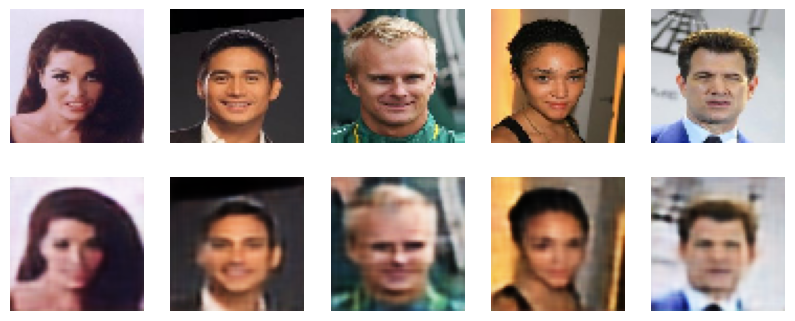

In [9]:
# Display sample and reconstructed images
display_images(autoencoder, x_test)

In [16]:
autoencoder.save('autoencoder-for-celeb.h5')